In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '40-efficientnetb3'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'


import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [5]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 512,
  "EPOCHS": 20,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "TTA_STEPS": 5,
  "BASE_MODEL": 'EfficientNetB3',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB3',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 512,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 20,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'TTA_STEPS': 5,
 'WIDTH': 256}

# Load data

In [8]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-c2f318ab381f072971d2adb35fbd1cf6f734c11ee731b63b7915ac3e'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

def data_augment_tta(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment_tta, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.000284 to 5.09e-05


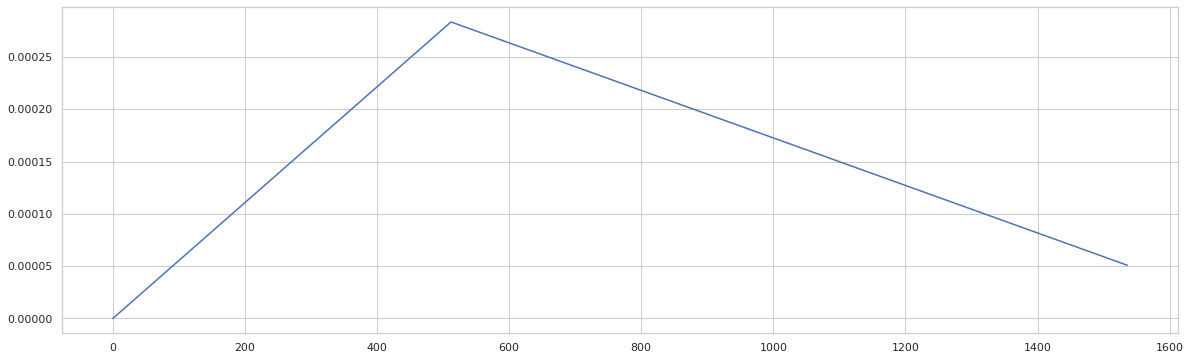

In [11]:
#@title
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 45365 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [12]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB3(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)

    # multi-sample dropout
    samples = []
    sample_mask = L.Dense(512, activation='relu')
    for n in range(16): # 16 samples
        sample = L.Dropout(.5)(x)
        sample = sample_mask(sample)
        sample = L.Dense(1, activation='sigmoid', name=f'sample_{n}')(sample)
        samples.append(sample)
    
    output = L.Average(name='output')(samples)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [13]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        train_size = count_data_items(train_filenames)

        step_size = train_size // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                     total_steps=total_steps, warmup_steps=warmup_steps, 
                                                     hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                     lr_max=lr_max, lr_min=lr_min)

            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=step_size,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        # Make predictions (last model)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)
        
        # Make predictions (best model)
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.91.11.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.91.11.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


43933696/43933088 [==============================] - 1s 0us/step
Epoch 1/20
93/93 - 63s - auc: 0.5634 - loss: 0.5666 - val_auc: 0.6661 - val_loss: 0.3383
Epoch 2/20
93/93 - 43s - auc: 0.8661 - loss: 0.2845 - val_auc: 0.8530 - val_loss: 0.2912
Epoch 3/20
93/93 - 43s - auc: 0.9004 - loss: 0.2628 - val_auc: 0.8741 - val_loss: 0.2893
Epoch 4/20
93/93 - 43s - auc: 0.9163 - loss: 0.2516 - val_auc: 0.9255 - val_loss: 0.2539
Epoch 5/20
93/93 - 40s - auc: 0.9281 - loss: 0.2425 - val_auc: 0.9065 - val_loss: 0.2674
Epoch 6/20
93/93 - 43s - auc: 0.9378 - loss: 0.2333 - val_auc: 0.9396 - val_loss: 0.2391
Epoch 7/20
93/93 - 43s - auc: 0.9493 - loss: 0.2219 - val_auc: 0.9452 - val_loss: 0.2250
Epoch 8/20
93/93 - 43s - auc: 0.9560 - loss: 0.2134 - val_auc: 0.9444 - val_loss: 0.2174
Epoch 9/20
93/93 - 40s - auc: 0.9627 - loss: 0.2034 - val_auc: 0.9515 - val_loss: 0.2183
Epoch 10/20
93/93 - 43s - auc: 0.9674 - loss: 0.1989 - val_auc: 0.9524 - val_loss: 0.2140
Epoch 11/20
93/93 - 43s - auc: 0.9721 - loss

INFO:tensorflow:Initializing the TPU system: grpc://10.91.11.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.91.11.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
93/93 - 62s - auc: 0.5730 - loss: 0.5230 - val_auc: 0.6672 - val_loss: 0.3441
Epoch 2/20
93/93 - 44s - auc: 0.8654 - loss: 0.2843 - val_auc: 0.8356 - val_loss: 0.2992
Epoch 3/20
93/93 - 43s - auc: 0.8980 - loss: 0.2634 - val_auc: 0.9019 - val_loss: 0.2831
Epoch 4/20
93/93 - 44s - auc: 0.9149 - loss: 0.2515 - val_auc: 0.9200 - val_loss: 0.2602
Epoch 5/20
93/93 - 44s - auc: 0.9279 - loss: 0.2415 - val_auc: 0.9387 - val_loss: 0.2412
Epoch 6/20
93/93 - 40s - auc: 0.9377 - loss: 0.2311 - val_auc: 0.9404 - val_loss: 0.2415
Epoch 7/20
93/93 - 44s - auc: 0.9488 - loss: 0.2204 - val_auc: 0.9514 - val_loss: 0.2219
Epoch 8/20
93/93 - 43s - auc: 0.9527 - loss: 0.2161 - val_auc: 0.9513 - val_loss: 0.2189
Epoch 9/20
93/93 - 44s - auc: 0.9616 - loss: 0.2059 - val_auc: 0.9563 - val_loss: 0.2158
Epoch 10/20
93/93 - 43s - auc: 0.9668 - loss: 0.1974 - val_auc: 0.9594 - val_loss: 0.2148
Epoch 11/20
93/93 - 40s - auc: 0.9709 - loss: 0.1904 - val_auc: 0.9612 - val_loss: 0.2157
Epoch 12/20
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.91.11.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.91.11.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
97/97 - 63s - auc: 0.5803 - loss: 0.5383 - val_auc: 0.6392 - val_loss: 0.3534
Epoch 2/20
97/97 - 44s - auc: 0.8702 - loss: 0.2810 - val_auc: 0.8121 - val_loss: 0.3088
Epoch 3/20
97/97 - 45s - auc: 0.9064 - loss: 0.2580 - val_auc: 0.9002 - val_loss: 0.2821
Epoch 4/20
97/97 - 45s - auc: 0.9206 - loss: 0.2467 - val_auc: 0.9166 - val_loss: 0.2797
Epoch 5/20
97/97 - 45s - auc: 0.9344 - loss: 0.2361 - val_auc: 0.9287 - val_loss: 0.2445
Epoch 6/20
97/97 - 45s - auc: 0.9427 - loss: 0.2267 - val_auc: 0.9377 - val_loss: 0.2377
Epoch 7/20
97/97 - 47s - auc: 0.9517 - loss: 0.2184 - val_auc: 0.9495 - val_loss: 0.2260
Epoch 8/20
97/97 - 42s - auc: 0.9583 - loss: 0.2091 - val_auc: 0.9483 - val_loss: 0.2269
Epoch 9/20
97/97 - 45s - auc: 0.9636 - loss: 0.2017 - val_auc: 0.9519 - val_loss: 0.2228
Epoch 10/20
97/97 - 45s - auc: 0.9695 - loss: 0.1943 - val_auc: 0.9512 - val_loss: 0.2217
Epoch 11/20
97/97 - 45s - auc: 0.9734 - loss: 0.1861 - val_auc: 0.9517 - val_loss: 0.2209
Epoch 12/20
97/97 -

## Model loss graph

Fold: 1


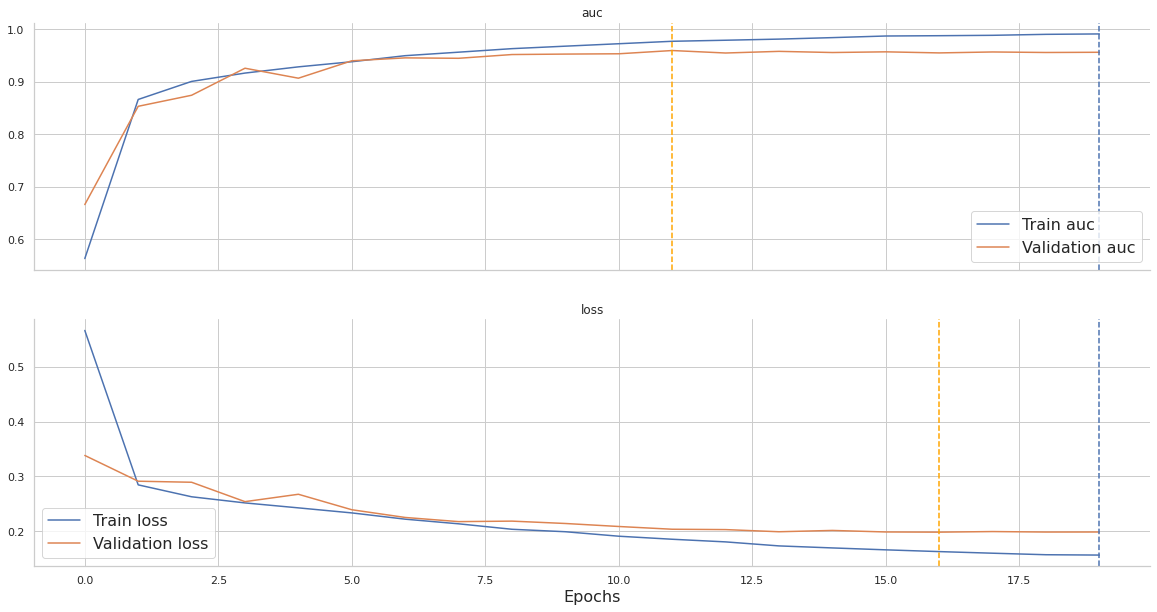

Fold: 2


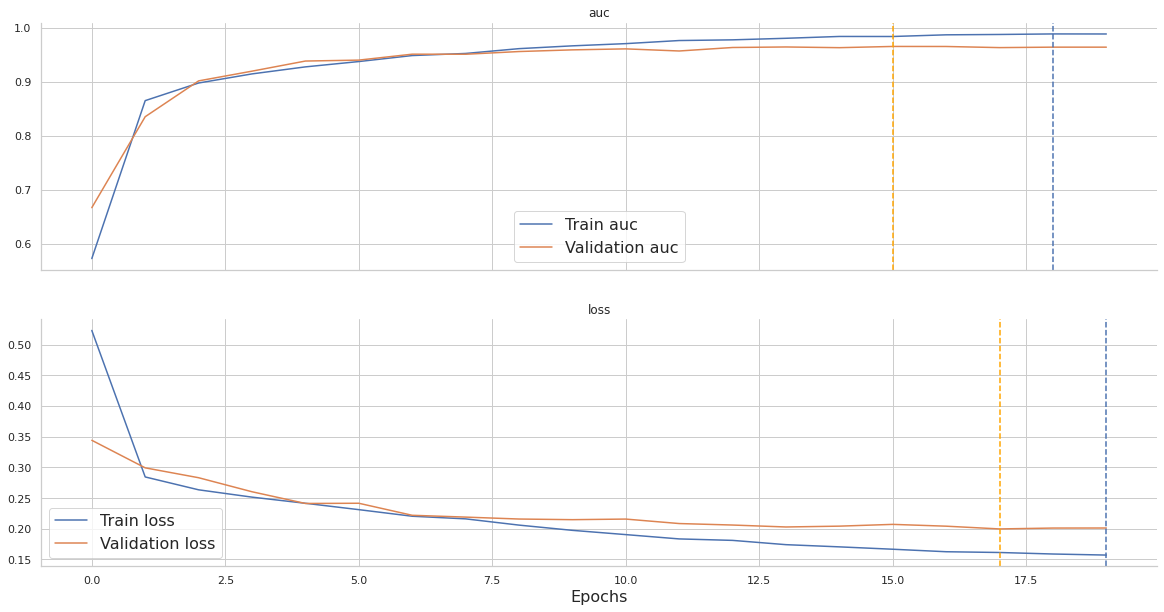

Fold: 3


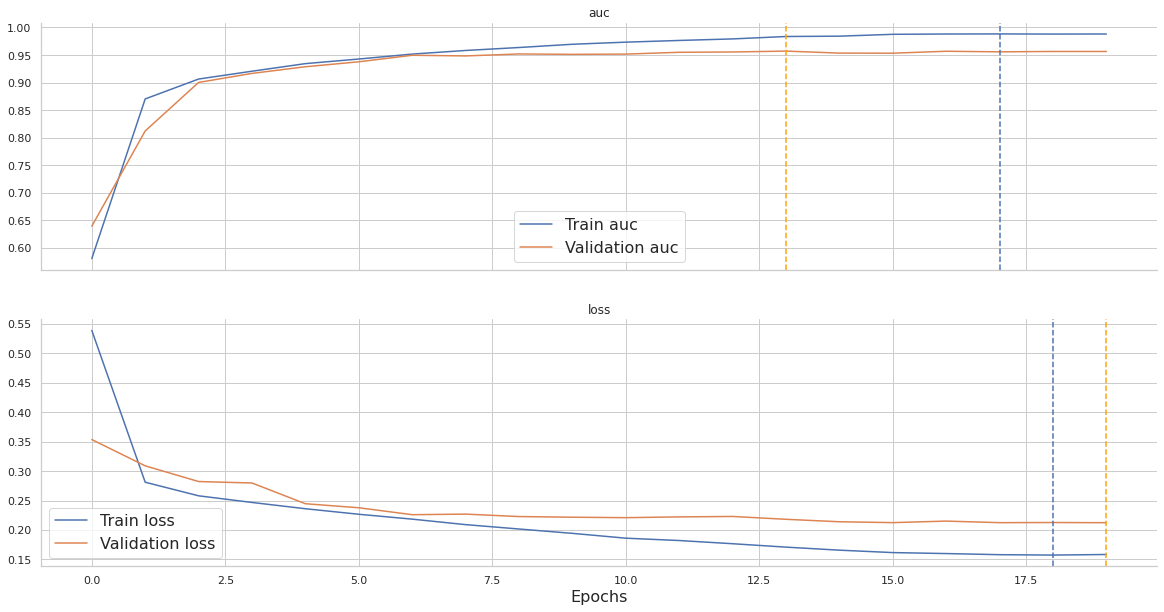

In [14]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

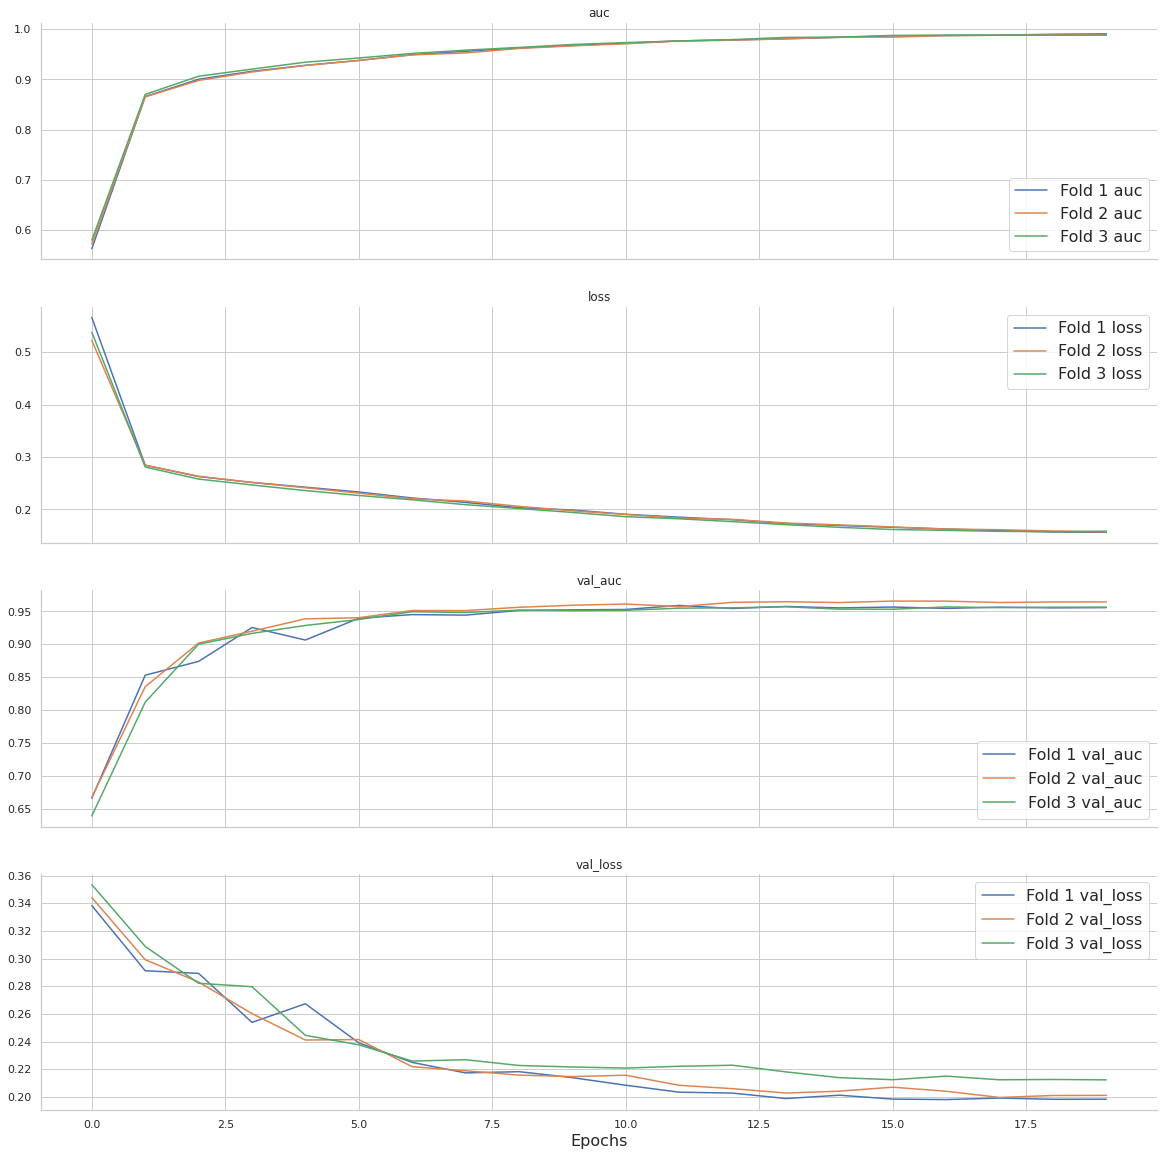

In [15]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [16]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.985540,0.894856,0.090684,0.987075,0.861179,0.986480,0.911596,0.983065,0.911794
Accuracy,0.994797,0.979922,0.014875,0.995072,0.982360,0.994646,0.977909,0.994674,0.979498
Precision,0.916079,0.415493,0.500587,0.930521,0.431818,0.908397,0.365385,0.909320,0.449275
Recall,0.775659,0.312848,0.462810,0.786164,0.355140,0.772727,0.311475,0.768085,0.271930
F1-score,0.840039,0.354942,0.485097,0.852273,0.389744,0.835088,0.336283,0.832757,0.338798
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


# Model evaluation by Subset

In [17]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.985540,0.894856,0.090684,0.987075,0.861179,0.986480,0.911596,0.983065,0.911794
male,0.988977,0.909229,0.079748,0.991569,0.901208,0.989821,0.919634,0.985539,0.906844
female,0.980193,0.867689,0.112504,0.979833,0.789879,0.981242,0.894652,0.979505,0.918538
head/neck,0.994810,0.906450,0.088360,0.996147,0.919903,0.991585,0.900452,0.996698,0.898994
upper extremity,0.981525,0.913379,0.068145,0.980339,0.909275,0.987309,0.911946,0.976927,0.918917
lower extremity,0.985146,0.840422,0.144724,0.986740,0.803112,0.987677,0.825000,0.981021,0.893154
torso,0.985452,0.903073,0.082379,0.988147,0.847301,0.985268,0.941382,0.982940,0.920535
0 <= age < 26,0.970270,0.839311,0.130959,0.981109,0.939130,0.976998,0.751025,0.952704,0.827778
26 <= age < 40,0.978322,0.785741,0.192581,0.986845,0.600170,0.986190,0.836572,0.961931,0.920482


# Model evaluation (best)

In [18]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.985339,0.896662,0.088677,0.986778,0.867661,0.986205,0.911143,0.983034,0.911182
Accuracy,0.994582,0.980372,0.014210,0.994276,0.982656,0.994760,0.978792,0.994711,0.979668
Precision,0.910903,0.428581,0.482322,0.901478,0.444444,0.917526,0.385417,0.913706,0.455882
Recall,0.767939,0.316347,0.451592,0.767296,0.373832,0.770563,0.303279,0.765957,0.271930
F1-score,0.833324,0.362067,0.471257,0.828992,0.406091,0.837647,0.339450,0.833333,0.340659
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.985339,0.896662,0.088677,0.986778,0.867661,0.986205,0.911143,0.983034,0.911182
male,0.988763,0.908956,0.079807,0.991180,0.900289,0.989578,0.920746,0.985532,0.905833
female,0.979944,0.873038,0.106907,0.979509,0.808661,0.980883,0.891812,0.979442,0.918640
head/neck,0.994175,0.910242,0.083932,0.994288,0.923771,0.991525,0.906414,0.996710,0.900542
upper extremity,0.981005,0.910607,0.070398,0.979442,0.902130,0.986568,0.911642,0.977004,0.918050
lower extremity,0.984869,0.844757,0.140111,0.986089,0.821227,0.987502,0.822923,0.981015,0.890122
torso,0.985342,0.905909,0.079433,0.988171,0.857110,0.985012,0.940034,0.982842,0.920584
0 <= age < 26,0.970518,0.837013,0.133505,0.982637,0.928261,0.976242,0.755464,0.952676,0.827315
26 <= age < 40,0.978053,0.786103,0.191950,0.986661,0.604893,0.985723,0.832385,0.961774,0.921030


# Confusion matrix

Fold: 1


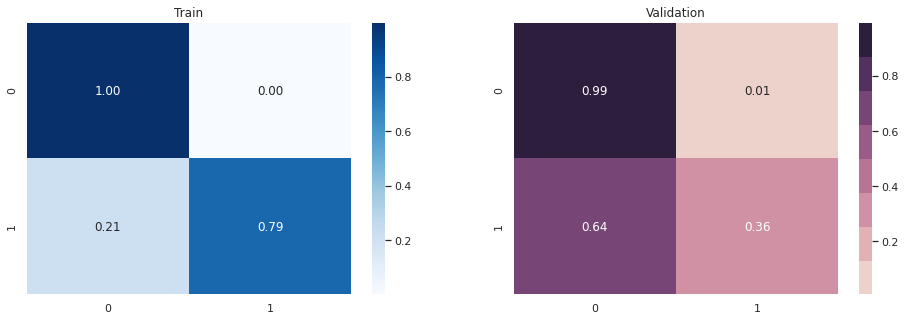

Fold: 2


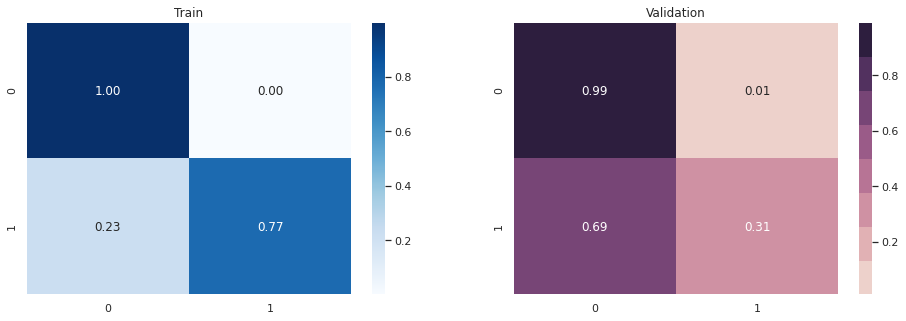

Fold: 3


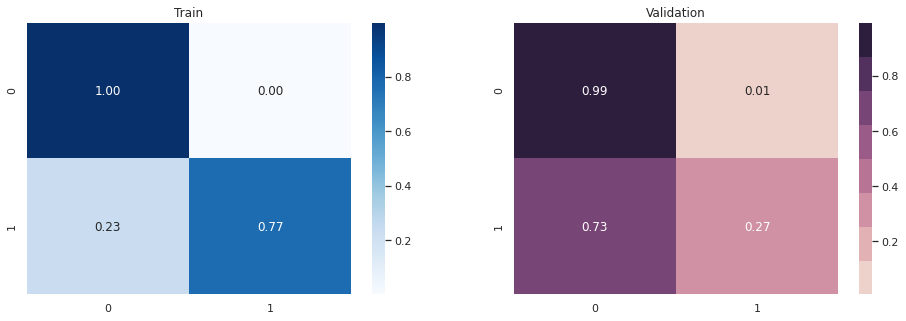

In [19]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [20]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.029580,0.043813,0.078158,0.025928
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.017418,0.028835,0.026973,0.031282
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.016055,0.024714,0.027906,0.027657
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.016291,0.026734,0.027626,0.027097
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.015005,0.027056,0.025151,0.022816
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.015856,0.027211,0.025194,0.026878
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.016752,0.026143,0.026685,0.030932
7,ISIC_0075663,female,35.0,torso,unknown,0,0.016339,0.029733,0.024748,0.027213
8,ISIC_0075914,male,30.0,torso,unknown,0,0.021395,0.049509,0.028465,0.028999
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.016758,0.029870,0.026342,0.027579


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.017203,0.026189,0.029547,0.030277
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.351272,0.744134,0.060805,0.951423
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.322014,0.679723,0.029753,0.900595
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.485350,0.932470,0.651978,0.842300
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.560797,0.962487,0.910129,0.931369
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.590026,0.977535,0.989197,0.983399
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.342608,0.323989,0.748467,0.640583
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.524030,0.810018,0.844360,0.965774
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.384944,0.076766,0.985494,0.862461
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.325473,0.924283,0.669941,0.033139


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.560797,0.962487,0.910129,0.931369
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.590026,0.977535,0.989197,0.983399
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.524030,0.810018,0.844360,0.965774
747,ISIC_0327406,male,40.0,upper extremity,melanoma,1,0.530988,0.784573,0.967684,0.902684
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.590380,0.982554,0.983685,0.985662
826,ISIC_0351666,male,80.0,head/neck,melanoma,1,0.547826,0.962337,0.865934,0.910860
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.568681,0.895296,0.975693,0.972418
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.583130,0.974192,0.980656,0.960801
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.584467,0.973614,0.981471,0.967248
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.545752,0.815125,0.939558,0.974077


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 239
Train positive correct predictions: 236


# Make predictions (best)

In [21]:
#@title
model_path_list = glob.glob(MODEL_BASE_PATH + 'model' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

3 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/40-efficientnetb3/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/40-efficientnetb3/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/40-efficientnetb3/model_fold_3.h5


In [24]:
#@title
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset)

    # TTA preds
    print('Running TTA')
    for step in range(config['TTA_STEPS']):
        test_preds_tta += model.predict(test_dataset_tta)

test_preds /= n_models
test_preds_tta /= (n_models * config['TTA_STEPS'])

image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(NUM_TEST_IMAGES)))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
# TTA
name_preds = dict(zip(image_names, test_preds_tta.reshape(NUM_TEST_IMAGES)))
test['target_tta'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/40-efficientnetb3/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/40-efficientnetb3/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/40-efficientnetb3/model_fold_3.h5


# Make predictions (last)

In [25]:
#@title
model_path_list = glob.glob(MODEL_BASE_PATH + 'last' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

3 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/40-efficientnetb3/last_model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/40-efficientnetb3/last_model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/40-efficientnetb3/last_model_fold_3.h5


In [26]:
#@title
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset)

    # TTA preds
    print('Running TTA')
    for step in range(config['TTA_STEPS']):
        test_preds_tta += model.predict(test_dataset_tta)

test_preds /= n_models
test_preds_tta /= (n_models * config['TTA_STEPS'])

image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(NUM_TEST_IMAGES)))
test['target_last'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
# TTA
name_preds = dict(zip(image_names, test_preds_tta.reshape(NUM_TEST_IMAGES)))
test['target_tta_last'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/40-efficientnetb3/last_model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/40-efficientnetb3/last_model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/40-efficientnetb3/last_model_fold_3.h5


# Visualize test predictions

In [27]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 151|10831
Test predictions (last) 153|10829
Test predictions 131|10851
Test predictions (last) 134|10848
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.025404,0.025800,0.023543,0.024119
1,ISIC_0052349,male,40.0,lower extremity,0.025647,0.025951,0.025426,0.025307
2,ISIC_0058510,female,55.0,torso,0.025399,0.025913,0.024392,0.024699
3,ISIC_0073313,female,50.0,torso,0.024705,0.025330,0.023719,0.024284
4,ISIC_0073502,female,45.0,lower extremity,0.024725,0.025247,0.025560,0.025591
5,ISIC_0074618,male,50.0,lower extremity,0.031905,0.033092,0.030214,0.030535
6,ISIC_0076801,male,45.0,upper extremity,0.025871,0.026207,0.027163,0.027001
7,ISIC_0077586,male,50.0,lower extremity,0.033427,0.032147,0.029510,0.029498
8,ISIC_0082004,female,45.0,torso,0.029577,0.029702,0.029777,0.029450
9,ISIC_0082785,male,65.0,lower extremity,0.025393,0.025892,0.026171,0.026445


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.925797,0.913282,0.938314,0.917042
42,ISIC_0155983,male,70.0,torso,0.679553,0.668733,0.663637,0.515685
69,ISIC_0182213,female,80.0,head/neck,0.768698,0.788839,0.460825,0.462224
102,ISIC_0208233,female,60.0,lower extremity,0.952352,0.952950,0.971712,0.959110
109,ISIC_0216447,male,80.0,head/neck,0.827876,0.849419,0.611014,0.649281
192,ISIC_0287325,male,60.0,torso,0.768749,0.702222,0.428301,0.442926
255,ISIC_0351156,male,40.0,head/neck,0.661320,0.689057,0.575099,0.603186
267,ISIC_0367988,male,70.0,torso,0.601823,0.607454,0.185622,0.199512
296,ISIC_0391046,male,85.0,torso,0.686387,0.656574,0.405716,0.412085
390,ISIC_0470699,male,90.0,torso,0.599536,0.605036,0.310851,0.387800


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.925797,0.913282,0.938314,0.917042
42,ISIC_0155983,male,70.0,torso,0.679553,0.668733,0.663637,0.515685
69,ISIC_0182213,female,80.0,head/neck,0.768698,0.788839,0.460825,0.462224
102,ISIC_0208233,female,60.0,lower extremity,0.952352,0.952950,0.971712,0.959110
109,ISIC_0216447,male,80.0,head/neck,0.827876,0.849419,0.611014,0.649281
192,ISIC_0287325,male,60.0,torso,0.768749,0.702222,0.428301,0.442926
255,ISIC_0351156,male,40.0,head/neck,0.661320,0.689057,0.575099,0.603186
267,ISIC_0367988,male,70.0,torso,0.601823,0.607454,0.185622,0.199512
296,ISIC_0391046,male,85.0,torso,0.686387,0.656574,0.405716,0.412085
390,ISIC_0470699,male,90.0,torso,0.599536,0.605036,0.310851,0.387800


# Test set predictions

In [28]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_tta'] = test['target_tta']
submission['target_last'] = test['target_last']
submission['target_tta_last'] = test['target_tta_last']

submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)
display(submission[['image_name', 'target']].head(10))
display(submission[['image_name', 'target']].describe())

print('TTA')
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)
display(submission_tta.head(10))
display(submission_tta.describe())

print('LAST')
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)
display(submission_last.head(10))
display(submission_last.describe())

print('TTA LAST')
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)
display(submission_tta_last.head(10))
display(submission_tta_last.describe())

,image_name,target
0,ISIC_0052060,0.025404
1,ISIC_0052349,0.025647
2,ISIC_0058510,0.025399
3,ISIC_0073313,0.024705
4,ISIC_0073502,0.024725
5,ISIC_0074618,0.031905
6,ISIC_0076801,0.025871
7,ISIC_0077586,0.033427
8,ISIC_0082004,0.029577
9,ISIC_0082785,0.025393


,target
count,10982.000000
mean,0.048942
std,0.099643
min,0.021570
25%,0.025754
50%,0.027550
75%,0.032096
max,0.989827


TTA


,image_name,target
0,ISIC_0052060,0.023543
1,ISIC_0052349,0.025426
2,ISIC_0058510,0.024392
3,ISIC_0073313,0.023719
4,ISIC_0073502,0.025560
5,ISIC_0074618,0.030214
6,ISIC_0076801,0.027163
7,ISIC_0077586,0.029510
8,ISIC_0082004,0.029777
9,ISIC_0082785,0.026171


,target
count,10982.000000
mean,0.048616
std,0.091901
min,0.022713
25%,0.026009
50%,0.028020
75%,0.033560
max,0.991780


LAST


,image_name,target
0,ISIC_0052060,0.025800
1,ISIC_0052349,0.025951
2,ISIC_0058510,0.025913
3,ISIC_0073313,0.025330
4,ISIC_0073502,0.025247
5,ISIC_0074618,0.033092
6,ISIC_0076801,0.026207
7,ISIC_0077586,0.032147
8,ISIC_0082004,0.029702
9,ISIC_0082785,0.025892


,target
count,10982.000000
mean,0.049071
std,0.099752
min,0.021845
25%,0.026092
50%,0.027770
75%,0.031971
max,0.989665


TTA LAST


,image_name,target
0,ISIC_0052060,0.024119
1,ISIC_0052349,0.025307
2,ISIC_0058510,0.024699
3,ISIC_0073313,0.024284
4,ISIC_0073502,0.025591
5,ISIC_0074618,0.030535
6,ISIC_0076801,0.027001
7,ISIC_0077586,0.029498
8,ISIC_0082004,0.029450
9,ISIC_0082785,0.026445


,target
count,10982.000000
mean,0.048520
std,0.091890
min,0.023191
25%,0.026330
50%,0.028180
75%,0.033265
max,0.991249
